## Gaussian Process for Time-Series Forecasting

<font color='red' size = 5>Problem Definition :</font> Model a Gaussian Process Regressor (GPR) for time-series forecasting in real-time with the aim of replacing a costly sensor by a cheaper sensor. With the deployment of GPR, we aim to replicate the reading of the expensive sensor given the readings of cheaper sensor in real-time.

<b>Plan :</b>
* Generate synthetic data for both sensors
* Implement GPR with sliding window approach ......Look into Woodbury Identity
* Visualize

### Generate Synthetic Data

Time interval $t \in [0, 30]$ with 3000 samples. 

Measurements from Expensive Sensor:
$\begin{equation}
    \begin{split}
    t \in [0, 5) &= 0.1 \ \mathcal{N}(0,1)\\
    t \in [5, 20) &= 10 + \sin(0.3t) + 0.1 \ \mathcal{N}(0,1)\\
    t \in [20,30] &= 0.1 \ \mathcal{N}(0,1)
    \end{split}
\end{equation}$ 

Measurements from Cheap Sensor:
$\begin{equation}
    \begin{split}
    t \in [0, 5) &= 0.3 \ \mathcal{N}(0,1) + 0.1\\
    t \in [5, 20) &= 9 + \sin(0.3t) + 0.01 (t-5) + 0.3 \ \mathcal{N}(0,1) + 0.8\\
    t \in [20,30] &= 0.01 (t-30) + 0.3 \ \mathcal{N}(0,1) + 0.1
    \end{split}
\end{equation}$ 

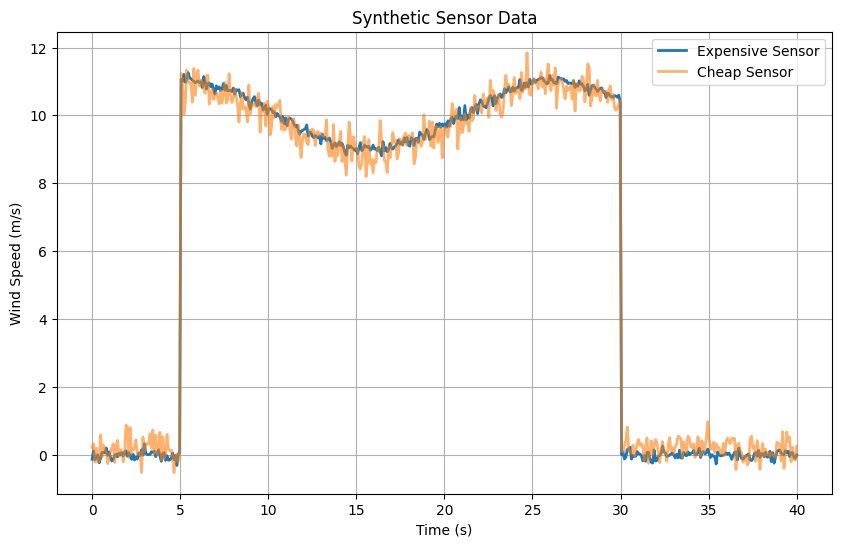

In [6]:
# Time variable
t = np.linspace(0, 40, 500)

# Expensive Sensor
expensive_sensor = np.piecewise(
    t,
    [t < 5, (t >= 5) & (t < 30), t >= 30],
    [lambda t: 0.1 * np.random.normal(0, 1, len(t)),
     lambda t: 10 + np.sin(0.3 * t) + 0.1 * np.random.normal(0, 1, len(t)),
     lambda t: 0.1 * np.random.normal(0, 1, len(t))]
)

# Cheap sensor
cheap_sensor = np.piecewise(
    t,
    [t < 5, (t >= 5) & (t < 30), t >= 30],
    [lambda t: 0.3 * np.random.normal(0, 1, len(t)) + 0.1,
     lambda t: 9 + np.sin(0.3 * t) + 0.01 * (t - 5) + 0.3 * np.random.normal(0, 1, len(t)) + 0.8,
     lambda t: 0.01 * (t - 30) + 0.3 * np.random.normal(0, 1, len(t)) + 0.1]
)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, expensive_sensor, label='Expensive Sensor', linewidth=2)
plt.plot(t, cheap_sensor, label='Cheap Sensor', linewidth=2, alpha = 0.6)
plt.xlabel('Time (s)')
plt.ylabel('Wind Speed (m/s)')
plt.title('Synthetic Sensor Data')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Convert to Tensor
expensive_sensor = torch.tensor(expensive_sensor)
cheap_sensor = torch.tensor(cheap_sensor)

### Sequential Gaussian Process for Online-Learning

During online-learning, it is more beneficial to update the model parameters than to re-fit the model from scratch with the new observations appended onto the existing data. <a href="https://gp-seminar-series.github.io/neurips-2022/assets/camera_ready/25.pdf">Sequential Gaussian Process for Online Learning of Non-stationary Functions</a>, introduce a sequential Monte-Carlo (SMC) algorithm to fit infinite mixtures of  GPs. SMC samplers can be adapted to allow real-time updates to the model parameters.

In a SMC setting with $j = 1, \cdots, J$ particles, we first propagate the particles $(z^{(j)}, \theta^{(j)}, \alpha^{(j)})$ from time $i-1$ to $i$ and fit a GP product-of-experts model. THen we calculate the particle weights. At the initial time, $i = 1$, the particle weight $j$ is: $$w_1^{(j)} \propto \mathbb{P}(y_1|z_1^{(j)}, x_1, \theta^{(j)}) \cdot \ \mathbb{P}(x_1 | z_1^{(j)}, \alpha^{(j)})$$
_______________________________________________________________
<font color = 'Red'> Algorithm 1: </font> <b>Online GP-MOE</b>  
_______________________________________________________________

<font color = 'orange'> Input: New Observation</font> $(x_i, y_i)$<br>

Particle Propagation*<br>
for $j = 1, \cdots, J $ in parallel do:<br>
$\quad$ $\bullet \ z_i^{(i)} \sim \mathbb{P}\big(z_i^{(i)}| \alpha^{(j)}, X_{1:i-1}\big);$
$\quad$ where $\ \mathbb{P}(z_i = k|\alpha, X_k) \propto \begin{cases}N'_k \cdot \mathcal{T}(\mu'_k, \Psi'_k, \nu'_k)\quad k \in K^+ \\ \alpha \cdot \mathcal{T}
(\mu_0, \Psi_0, \nu_0)\ \ \ \quad \text{o.w.} \end{cases}$

$\\ \quad$ $\bullet \ \theta_{z_i}^{(j)} \sim $ elliptical slice sampler


$\\ \quad \bullet \ \alpha^{(j)} \sim \mathbb{P}\big( \alpha^{(j)}|z_{1:i} \big) = (1 - \pi_\alpha)\cdot \Gamma (\alpha_0 + K -1, b_0 - \log \rho) + \pi_\alpha \cdot \Gamma (\alpha_0 + K, b_0 - \log \rho)$; $\quad$  

$\\ \quad \quad$ where $\ \rho|\alpha \sim \text{Beta}(\alpha+1, i), \ K = |\{k:N_k>0\}|$, $\large \frac{\pi_\alpha}{1 - \pi_\alpha} = \frac{a_0 + K -1 }{N(b_0 - \log \rho)}$

$\\ \quad$ $\bullet$ Update Particle Weight: 

$\\ \quad \quad$ $w_i^{(j)} := w_i^{(j-1)} \cdot \Large \frac{\mathbb{P}\big(y_{z^{(i)}} | X_{z_i^{(j)}}, \theta^{(j)}_{z_i^{(j)}} \big)}{\mathbb{P}\big(y'_{z^{(i)}} | X'_{z_i^{(j)}}, \theta'^{(j)}_{z_i^{(j)}} \big)}$ $\cdot \ \mathbb{P}(x_i|z_i^{(j)}, \alpha^{(j)})$

$\\ \quad \quad$ where; $(X'_k, y'_k) = (x_{i'}, y_{i'}, i' : (z_{i'} = k, i' < i))$ and $(X_k, y_k) = (x_i, y_i, i : z_i = k)$

Normalize Weight, $w_i^{(j)} := w_{i}^{(j)} / \sum_{j=1}^J w_i^{(j)}$

Particle Resampling*<br>
if $N_{eff}<J/2$ then:
$\\ \quad$ $\bullet$ Resample particles $\bigg(z_{1:i}^{(j*)}, \theta^{(j*)}, \alpha^{(j*)} \bigg)$ from $j* \sim \text{Multinomial} \bigg(J, w_i^{(1)}, \cdots, w_i^{(J)} 
\bigg)$
$\\ \quad$ $\bullet$ Set $w_i^{(j)} := 1/J \ \forall \ j=1, \cdots, J$ 

<font color = 'orange'> Output: Particle Weights </font> $\bigg(w_i^{(1)}, \cdots, w_i^{(J)} \bigg)$ and <font color = 'orange'> particles </font>$\bigg( z_{1:t}^{(1:J)}, \theta^{(1:J)}, \alpha^{(1:J)} \bigg)$

_______________________________________________________________
<font color = 'Red'> Algorithm 2: </font> <b>GP-MOE Prediction</b>  
_______________________________________________________________

for $j = 1, \cdots, J $ in parallel do:

$\quad$ Predict new observations on particle $j$ with

$\\ \quad \bullet p_k \propto N_k \cdot \mathbb{P}(x_*|Z_* = k, X_k , -)$ 
$\\ \quad \bullet \mathbb{P}(y_*^{(i)} | y, X, x_*, -) = \sum_{k \in K^+} p_k \cdot \mathbb{P}(y_k, X_k, x_*, -)$

Average Predictions: $\mathbb{P}(\bar{y}_*|y, X, x_*) = \sum_{j=1}^J w^{(j)}_i \ \mathbb{P}(y^{(i)}_* | y, X, -) $

In [1]:
import torch
import pyro
import pyro.distributions as dist

In [81]:
dist.MultivariateStudentT(df = torch.tensor([100.]), loc = torch.tensor([0.]), scale_tril = torch.tensor([[1.0]])).log_prob(torch.tensor([3.0])).exp()

tensor([0.0051])

In [ ]:
assignments = [0, 1, 1, 0, 2, 3, 3, 2, 0]
observations = [1, 2, 3, 4, 5, 6, 7, 8, 9]

In [124]:
assignments = [torch.tensor([0.]), torch.tensor([1.]), torch.tensor([1.]), torch.tensor([0.]), torch.tensor([2.]), torch.tensor([3.]), torch.tensor([3.]), 
               torch.tensor([2.]), torch.tensor([0.])]
observations = [torch.tensor([1.]), torch.tensor([2.]), torch.tensor([3.]), torch.tensor([4.]), torch.tensor([5.]), torch.tensor([6.]), torch.tensor([7.]), 
                torch.tensor([8.]), torch.tensor([9.])]

# Convert assignments and observations to torch tensors
assignments_tensor = torch.tensor(assignments)
observations_tensor = torch.tensor(observations)

# Retrieve indices where z=2
indices = (assignments_tensor == 2).nonzero(as_tuple=True)[0]

# Retrieve the corresponding values of X
X_values_for_z2 = observations_tensor[indices]

In [125]:
X_values_for_z2

tensor([5., 8.])

In [137]:
k = 10
assert len(X_values_for_z2) == 3, 'Length of Tensor Xk must equal No. of Data Points in Cluster {}'.format(k)

AssertionError: Length of Tensor Xk must equal No. of Data Points in Cluster 10

In [201]:
def Chinese_Restaurant_Prior(alpha, cluster_counts, x, observations, assignments):
    '''
        Args:
            args: See parse_arguments() for details
            alpha: Concentration parameter for Dirichlet Process (DP)
            cluster_counts: Maintains the count of data points in each cluster. Its index gives the corresponding cluster ID
            x: Current observation --- must be a tensor
            observations: List of previous observations
            assignments: Keeps Track of the cluster assignments for each data point -- tells how data points are distributed across clusters
        
        Returns:
            zi: Categorical value representing which cluster does x belongs to 

    '''

    n_clusters = len(cluster_counts)
    # probs holds probability based on existing cluster sizes and the t-distribution for each existing cluster i.e. probs[0], prob[1],...prob[n_clusters-1]
    probs = torch.zeros(n_clusters + 1)

    assignments_tensor = torch.tensor(assignments)
    observations_tensor = torch.tensor(observations)

    for k in range(n_clusters):
        # Get data-points corresponding to cluster 'k'
        indices = (assignments_tensor == k).nonzero(as_tuple=True)[0]
        X_k_prime = observations_tensor[indices]

        N_k_prime = cluster_counts[k]               # No. of Data Points in Cluster k until (i-1)th observation
        nu_k_prime = 3.0 + N_k_prime           # D = 1 since the data is 1-D
        lambda_k_prime = 0.5 + N_k_prime

        assert len(X_k_prime) == N_k_prime, 'Length of Tensor Xk must equal No. of Data Points in Cluster {}'.format(k)

        xk_bar_prime = torch.sum(X_k_prime)/N_k_prime                                                  # TODO: Need to include present observation?
        S_k_prime = torch.sum(X_k_prime ** 2) - 2 * xk_bar_prime * torch.sum(X_k_prime) + N_k_prime * (xk_bar_prime ** 2)
        S_xk_prime = (0.5 * N_k_prime * (xk_bar_prime - 0)**2)/lambda_k_prime
        frac = (lambda_k_prime + 1)/(lambda_k_prime * nu_k_prime)
        add = 1.0 + S_k_prime + S_xk_prime

        mu_k_prime = (0.5 * 0 + N_k_prime * xk_bar_prime) / lambda_k_prime            # TODO: check if its x_bar or x_bar_prime
        Psi_k_prime = frac * add
        
        # Probability of data falling in existing k-th cluster
        probs[k] = N_k_prime * dist.MultivariateStudentT(df = torch.tensor([nu_k_prime]), 
                                                         loc = torch.tensor([mu_k_prime]), 
                                                         scale_tril = torch.tensor([[Psi_k_prime]])).log_prob(x).exp()
    
    # Probability of Forming a New Cluster
    probs[-1] = alpha * dist.MultivariateStudentT(df = torch.tensor([3.0]), 
                                                  loc = torch.tensor([0.0]), 
                                                  scale_tril = torch.tensor([[1.0]])).log_prob(x).exp()

    # Normalize
    probs /= probs.sum()

    return pyro.sample('z', dist.Categorical(probs))

In [202]:
cluster_counts = []
assignments = []
X = []
observation = torch.tensor([0.5, 1.0, 2.0, 5.0])
alpha = pyro.sample('beta', dist.Beta(1.0,1.0))

for i, x in enumerate(observation):
        if i == 0:
            # Initialize New Cluster
            z = pyro.sample('z_0', dist.Categorical(torch.tensor([1.0])))
            cluster_counts.append(1)


        else:
            z = Chinese_Restaurant_Prior(alpha = alpha, cluster_counts = cluster_counts, x = x.unsqueeze(-1), observations = X, assignments = assignments)
            if z == len(cluster_counts):
                # Implies that a new cluster has been created
                cluster_counts.append(1)
            else:
                # Implies that x belongs to an existing cluster
                cluster_counts[z] += 1
        
        X.append(x)
        assignments.append(z)

In [203]:
print ('cluster_counts:', cluster_counts)
print ('X:', X)
print ('assignments:', assignments)

cluster_counts: [3, 1]
X: [tensor(0.5000), tensor(1.), tensor(2.), tensor(5.)]
assignments: [tensor(0), tensor(0), tensor(0), tensor(1)]


### Time-series Canadian CO2 Dataset

In [2]:
import pandas as pd

df = pd.read_csv('co-emissions-per-capita.csv')
df.head()

,Entity,Code,Year,Annual CO₂ emissions (per capita)
0,Afghanistan,AFG,1949,0.001992
1,Afghanistan,AFG,1950,0.011266
2,Afghanistan,AFG,1951,0.012098
3,Afghanistan,AFG,1952,0.011946
4,Afghanistan,AFG,1953,0.013685


In [3]:
canada_df = df[df['Entity'] == 'Canada']
year = canada_df['Year']
emission = canada_df['Annual CO₂ emissions (per capita)']

year = torch.tensor(year.values, dtype = torch.float32)
emission = torch.tensor(emission.values, dtype = torch.float32)

In [4]:
dataset = torch.stack((year, emission), dim = 1)

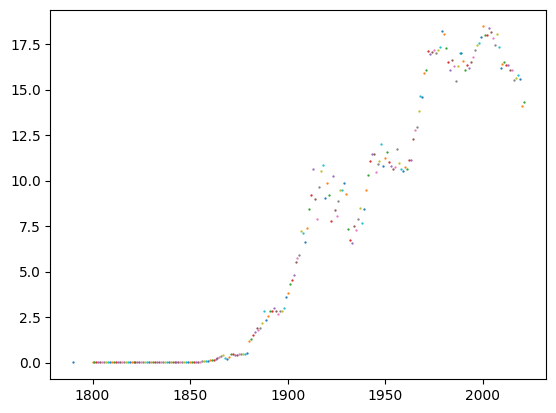

In [93]:
import matplotlib.pyplot as plt
for i, data in enumerate(dataset):
    x, y = data
    plt.scatter(x,y, s = 0.4)

In [8]:
torch.save(dataset, 'Canada_data.pt')

In [10]:
data = torch.load('Canada_data.pt')

In [12]:
data.shape

torch.Size([223, 2])

## Kalman Filter


Ornstein-Uhlenbeck process: $$dX_t = \theta(\mu - X_t)dt + \sigma dW_t$$
$\mu$ is the mean to which the process reverts,

$\theta$ is the rate of reversion, 

$\sigma$ is the volatility and 

$dW_t$ is the Wiener increment which is normally distributed with mean zero and variance $dt$.

To simulate the OU process, use the Euler-Maruyama method for discretizing the SDE: $$X_{t + \Delta t} = X_t + \theta(\mu - X_t)\Delta t + \sigma \sqrt{\Delta t}Z$$
$Z \sim \mathcal{N}(0,1)$ 

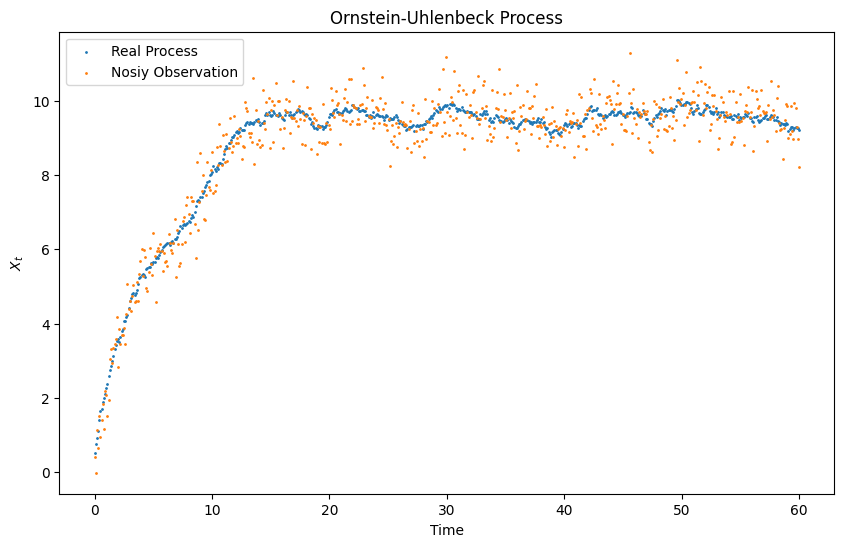

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
theta = 0.15  # Rate of reversion
mu = 10.0      # Mean
sigma = 0.2   # Volatility
T = 60.0      # Total time
dt = 0.1     # Time step
N = int(T/dt) # Number of steps
x0 = 0.5     # Initial x0 value

X_real = np.zeros(N)
X_real[0] = x0
np.random.seed(0)

for t in range(1, N):
    Z = np.random.normal(0, 1)
    X_real[t] = X_real[t-1] + theta * (mu - X_real[t-1]) * dt + sigma * np.sqrt(dt) * Z

# Simulated observations (adding Gaussian noise)
observation_noise_stddev = 0.5
y = X_real + np.random.normal(0, observation_noise_stddev, N)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(np.linspace(0, T, N), X_real, s = 1, label = 'Real Process')
plt.scatter(np.linspace(0, T, N), y, s = 1, label = 'Nosiy Observation')
plt.xlabel('Time')
plt.ylabel('$X_t$')
plt.legend()
plt.title('Ornstein-Uhlenbeck Process')
plt.show()


## Kalman Filter Initialization

$A = [1 - \theta dt]$, $B = [\theta \mu \ dt]$, $C = [1]$, 

$Q = [(\sigma \sqrt{dt})^2]$, $R = [y^2]$, $P = Q$

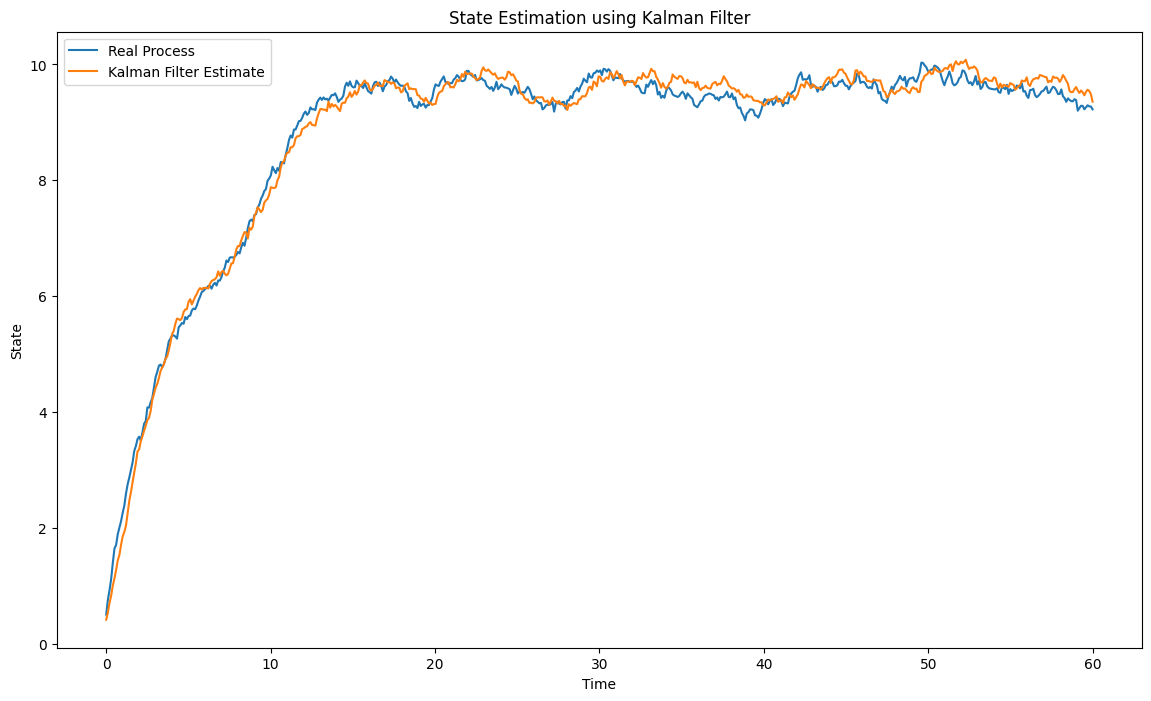

In [2]:
# Kalman filter initialization
A = 1 - theta * dt
B = theta * mu * dt
C = 1
Q = (sigma * np.sqrt(dt)) ** 2  # Process noise covariance
R = observation_noise_stddev ** 2  # Observation noise covariance
P = Q  # Initial estimate of state covariance
X_est = np.zeros(N)
X_est[0] = y[0]  # Initializing with the first observation

# Kalman filtering
for t in range(1, N):
    # Prediction
    X_pred = A * X_est[t-1] + B
    P_pred = A * P * A + Q

    # Update
    K = P_pred * C / (C * P_pred * C + R)
    X_est[t] = X_pred + K * (y[t] - C * X_pred)
    P = (1 - K * C) * P_pred

# Visualization
plt.figure(figsize=(14, 8))
plt.plot(np.linspace(0, T, N), X_real, label='Real Process')
#plt.plot(np.linspace(0, T, N), y, label='Observations')
plt.plot(np.linspace(0, T, N), X_est, label='Kalman Filter Estimate')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.title('State Estimation using Kalman Filter')
plt.show()

For Linear-Time-Invariant (LTI) Ornstein-Uhlenbeck Process: $$dx = -\lambda x \ dt + d \beta$$ with $\lambda > 0$ and with the Brownian motion having a diffusion constant $q$; we get the transition density: $$p(x(t) | x(s)) = \mathcal{N}(m(t|s), P(t|s))$$
where; $m(t|s) = \exp(-\lambda (t-s)) x(s)$;

$P(t|s) = \frac{q}{2\lambda}\bigg[1 - \exp(-2\lambda (t-s))\bigg]$

The corresponding discretization matrices (scalars) are then given by:
$a_k = \exp(-\lambda \Delta t_k)$
$\Sigma_k = \frac{q}{2\lambda} \bigg[1 - \exp (-2\lambda \Delta t_k)\bigg]$ and $\Delta t_k = t_{k+1} - t_k$

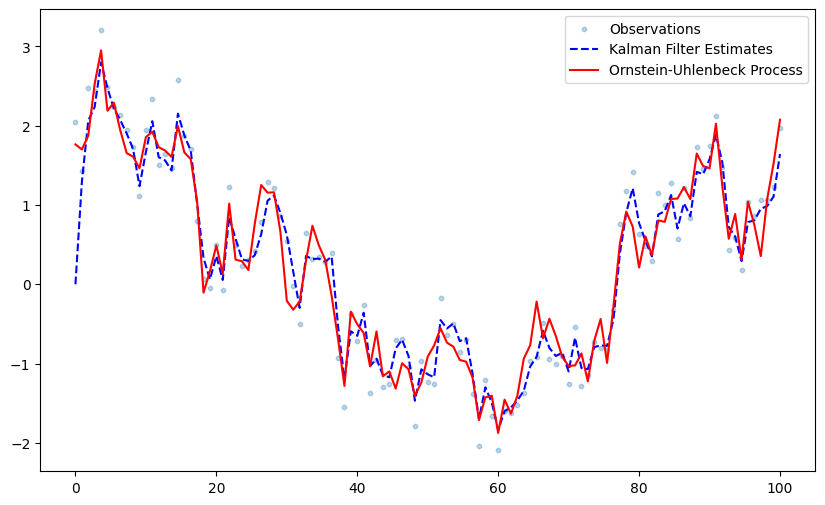

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Initial mean and covariance
m0 = 0.0
P0 = 1.0

# Parameters for OU process
lambdaa = 0.15
q = 0.2
R = 0.1 # Observation noise
T = 100.0
dt = 0.9
N = int(T / dt)

# Initialize arrays
m_k = np.zeros(N)
P_k = np.zeros(N)

# Initial values
m_k[0] = m0
P_k[0] = P0

# Generate observations (for testing)
np.random.seed(0)
x = np.zeros(N)
x[0] = np.random.normal(loc=m0, scale=np.sqrt(P0))
for t in range(1, N):
    x[t] = np.exp(-lambdaa * dt) * x[t-1] + np.sqrt(q/(2*lambdaa) * (1 - np.exp(-2*lambdaa*dt))) * np.random.normal(0, 1)
y = x + np.random.normal(0, np.sqrt(R), N)

# Kalman filter
for t in range(1, N):
    # Prediction step
    m_pred = np.exp(-lambdaa * dt) * m_k[t-1]
    P_pred = np.exp(-2*lambdaa * dt) * P_k[t-1] + (q/(2*lambdaa)) * (1 - np.exp(-2*lambdaa*dt))

    # Update step
    m_k[t] = m_pred + (P_pred/(P_pred + R)) * (y[t] - m_pred)
    P_k[t] = P_pred - (P_pred**2/(P_pred + R))

# Visualization (Optional)
plt.figure(figsize=(10, 6))
plt.scatter(np.linspace(0, T, N), y, label='Observations', alpha = 0.3, s = 10)
plt.plot(np.linspace(0, T, N), m_k, label='Kalman Filter Estimates', color = 'blue', linestyle = '--')
plt.plot(np.linspace(0, T, N), x, label = 'Ornstein-Uhlenbeck Process', color = 'red')
plt.legend()
plt.show()

In [10]:
for i in range(N):
    

9.0909091

In [27]:
mean = []
var = []
dt = 0.01
m_prev = m_k[-1]
P_prev = P_k[-1]

mean_holder = []
var_holder = []

for i in range(10):
    mean_i = np.exp(-0.15*dt) * m_prev
    P_i = (0.2/(2*0.15)) * (1 - np.exp(-2*0.15 * dt)) + np.exp(-2*0.15 * dt) * P_prev
    mean_holder.append(mean_i)
    var_holder.append(P_i)
    m_prev = mean_i
    P_prev = P_i

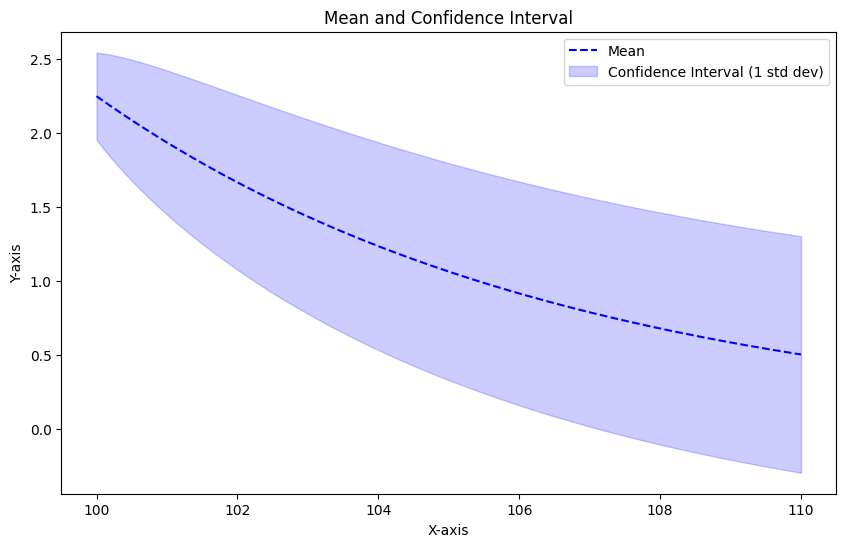

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data (replace this with your mean and variance arrays)
MEAN = mean_holder
variance = var_holder

# Calculate standard deviation
std_dev = np.sqrt(variance)

# Create the figure and the line that will show the mean

x_new = np.linspace(100,110,1000)
plt.figure(figsize=(10, 6))
plt.plot(x_new, MEAN, label='Mean', color='blue', linestyle = '--')

# Use fill_between to create the confidence interval (using one standard deviation)
plt.fill_between(x_new, MEAN - std_dev, MEAN + std_dev, color='blue', alpha=0.2, label='Confidence Interval (1 std dev)')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Mean and Confidence Interval')
plt.legend()

# Show the plot
plt.show()


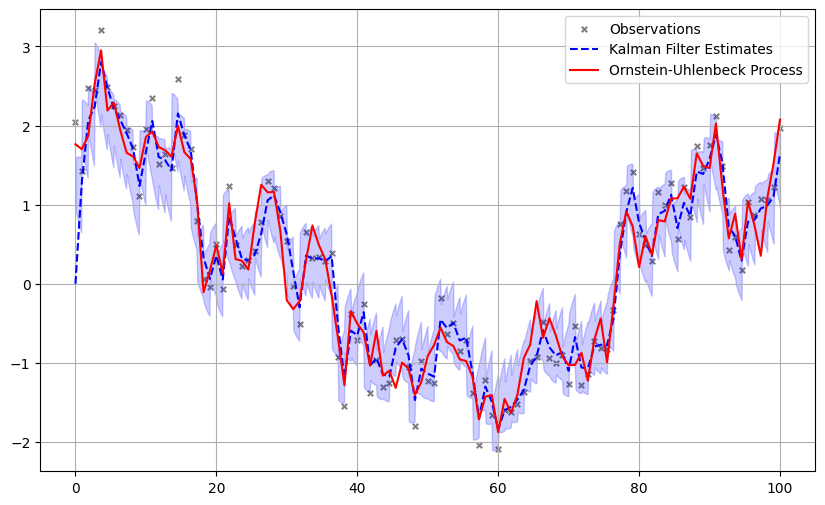

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Initial mean and covariance
m0 = 0.0
P0 = 1.0

# Parameters for OU process
lambdaa = 0.15
q = 0.2
R = 0.1 # Observation noise
T = 100.0
dt = 0.9
N = int(T / dt)

# Intermediate time step for plotting
dt_intermediate = 0.10
N_intermediate = int(dt / dt_intermediate)

# Initialize arrays
m_k = np.zeros(N)
P_k = np.zeros(N)
m_intermediate = []
P_intermediate = []

# Initial values
m_k[0] = m0
P_k[0] = P0

# Generate observations (for testing)
np.random.seed(0)
x = np.zeros(N)
x[0] = np.random.normal(loc=m0, scale=np.sqrt(P0))
for t in range(1, N):
    x[t] = np.exp(-lambdaa * dt) * x[t-1] + np.sqrt(q/(2*lambdaa) * (1 - np.exp(-2*lambdaa*dt))) * np.random.normal(0, 1)
y = x + np.random.normal(0, np.sqrt(R), N)

# Kalman filter
for t in range(1, N):
    # Prediction step
    m_pred = np.exp(-lambdaa * dt) * m_k[t-1]
    P_pred = np.exp(-2*lambdaa * dt) * P_k[t-1] + (q/(2*lambdaa)) * (1 - np.exp(-2*lambdaa*dt))

    # Update step
    m_k[t] = m_pred + (P_pred/(P_pred + R)) * (y[t] - m_pred)
    P_k[t] = P_pred - (P_pred**2/(P_pred + R))

    # Intermediate prediction step
    m_temp = m_k[t]
    P_temp = P_k[t]
    for _ in range(N_intermediate):
        m_temp = np.exp(-lambdaa * dt_intermediate) * m_temp
        P_temp = np.exp(-2*lambdaa * dt_intermediate) * P_temp + (q/(2*lambdaa)) * (1 - np.exp(-2*lambdaa*dt_intermediate))
        m_intermediate.append(m_temp)
        P_intermediate.append(P_temp)

# Visualization (Optional)
plt.figure(figsize=(10, 6))
plt.scatter(np.linspace(0, T, N), y, label='Observations', alpha = 0.5, s = 15, marker = 'x', color = 'black')
plt.plot(np.linspace(0, T, N), m_k, label='Kalman Filter Estimates', color = 'blue', linestyle = '--')
plt.plot(np.linspace(0, T, N), x, label = 'Ornstein-Uhlenbeck Process', color = 'red')
#plt.plot(np.linspace(0, T, N_intermediate * (N - 1)), m_intermediate, label='Intermediate Estimates', color='green', linestyle='--')
plt.fill_between(np.linspace(0, T, N_intermediate * (N - 1)), np.array(m_intermediate) - np.sqrt(P_intermediate), np.array(m_intermediate) + np.sqrt(P_intermediate), color='blue', alpha=0.2)
plt.legend()
plt.grid()
plt.show()

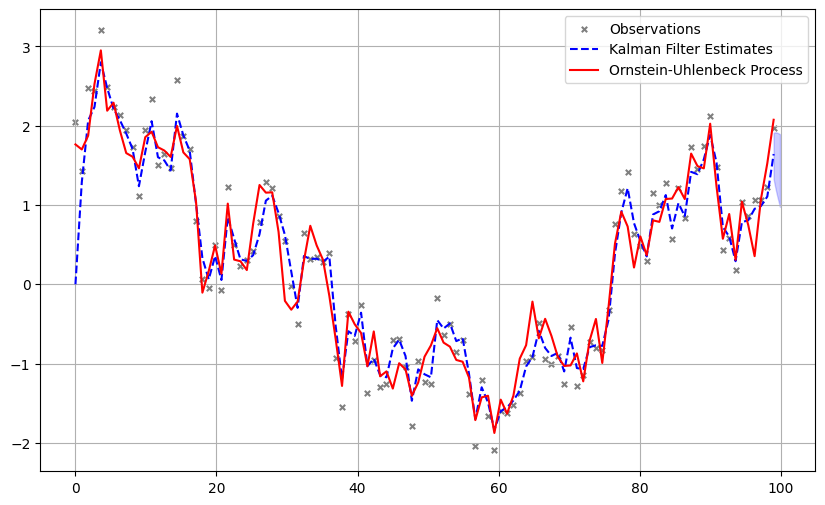

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Create a directory to save the figures
save_dir = "saved_plots"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Initial mean and covariance
m0 = 0.0
P0 = 1.0

# Parameters for OU process
lambdaa = 0.15
q = 0.2
R = 0.1
T = 100.0
dt = 0.9
N = int(T / dt)

# Intermediate time step for plotting
dt_intermediate = 0.10
N_intermediate = int(dt / dt_intermediate)

# Initialize arrays
m_k = np.zeros(N)
P_k = np.zeros(N)

# Generate observations
np.random.seed(0)
x = np.zeros(N)
x[0] = np.random.normal(loc=m0, scale=np.sqrt(P0))

for t in range(1, N):
    x[t] = np.exp(-lambdaa * dt) * x[t-1] + np.sqrt(q/(2*lambdaa) * (1 - np.exp(-2*lambdaa*dt))) * np.random.normal(0, 1)
y = x + np.random.normal(0, np.sqrt(R), N)

# Initial values
m_k[0] = m0
P_k[0] = P0

# Set up the plot
plt.figure(figsize=(10, 6))
plt.grid()

# Kalman filter and visualization
for t in range(1, N):
    # Prediction step
    m_pred = np.exp(-lambdaa * dt) * m_k[t-1]
    P_pred = np.exp(-2*lambdaa * dt) * P_k[t-1] + (q/(2*lambdaa)) * (1 - np.exp(-2*lambdaa*dt))

    # Update step
    m_k[t] = m_pred + (P_pred / (P_pred + R)) * (y[t] - m_pred)
    P_k[t] = P_pred - (P_pred ** 2 / (P_pred + R))

    # Intermediate prediction step and confidence interval
    m_intermediate = []
    P_intermediate = []
    m_temp = m_k[t]
    P_temp = P_k[t]
    for _ in range(N_intermediate):
        m_temp = np.exp(-lambdaa * dt_intermediate) * m_temp
        P_temp = np.exp(-2*lambdaa * dt_intermediate) * P_temp + (q/(2*lambdaa)) * (1 - np.exp(-2*lambdaa*dt_intermediate))
        m_intermediate.append(m_temp)
        P_intermediate.append(P_temp)

    # Update plot
    plt.clf()
    plt.grid()
    plt.scatter(np.linspace(0, t*dt, t+1), y[:t+1], label='Observations', alpha=0.5, s=15, marker='x', color='black')
    plt.plot(np.linspace(0, t*dt, t+1), m_k[:t+1], label='Kalman Filter Estimates', color='blue', linestyle='--')
    plt.plot(np.linspace(0, t*dt, t+1), x[:t+1], label='Ornstein-Uhlenbeck Process', color='red')
    plt.fill_between(np.linspace(t*dt, (t+1)*dt, N_intermediate), np.array(m_intermediate) - np.sqrt(P_intermediate), np.array(m_intermediate) + np.sqrt(P_intermediate), color='blue', alpha=0.2)
    plt.legend()
    
    # Save figure
    plt.savefig(os.path.join(save_dir, f'frame_{t:04d}.png'))

plt.show()

In [11]:
import imageio
import os

# Directory where the images are saved
save_dir = "saved_plots"

# Output GIF filename
output_gif_filename = "output_animation.gif"

# Collect filenames
filenames = [os.path.join(save_dir, f'frame_{t:04d}.png') for t in range(1, N)]

# Create a GIF
with imageio.get_writer(output_gif_filename, mode='I', fps = 3) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)


/tmp/ipykernel_10150/3651275450.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## Visualize Image Segmentation with COCO .json File

In [1]:
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
coco = COCO('Gdansk Airport Labeling/instances_default.json')
img_dir = 'Gdansk Airport Labeling'
image_id = 6

img = coco.imgs[image_id]

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [3]:
img

{'id': 6,
 'width': 1920,
 'height': 1024,
 'file_name': 'gdansk-supervideo-64px-00_09_10-00007.jpg',
 'license': 0,
 'flickr_url': '',
 'coco_url': '',
 'date_captured': 0}

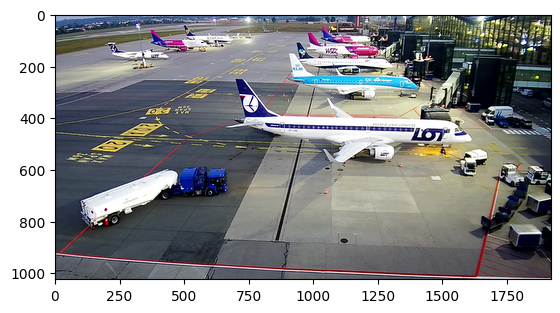

In [4]:
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='lanczos')
plt.show()

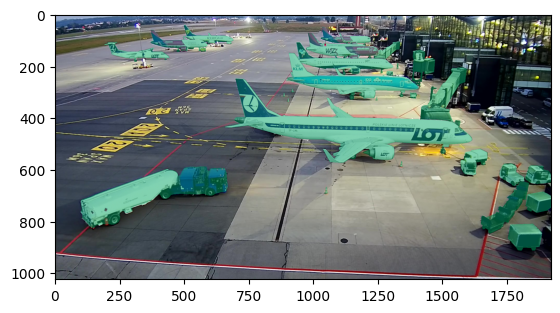

In [5]:
# See Overlay
plt.imshow(image)
cat_ids = coco.getCatIds()
anns_id = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_id)
coco.showAnns(anns, draw_bbox=False)

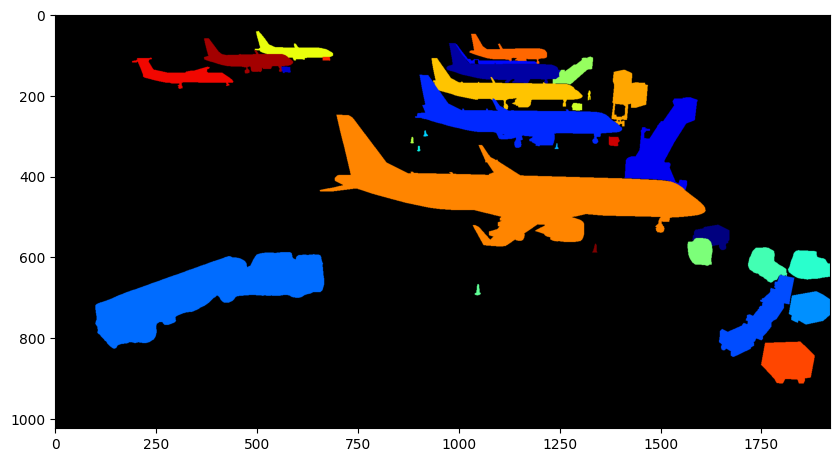

In [6]:
# See mask --- Different masks

# Create an empty mask
mask = np.zeros((image.shape[0], image.shape[1], 3), dtype = np.uint8)

# Define colormap to use for the different masks
colors = plt.cm.jet(np.linspace(0,1,len(anns)))

for i, ann in enumerate(anns):
    # Get the mask for this annotation
    ann_mask = coco.annToMask(ann)

    # Use color defined by the colormap
    mask[ann_mask > 0] = (colors[i, :3]*255).astype(np.uint8)

# Display
plt.figure(figsize=(10,15))
plt.imshow(mask)
plt.show()

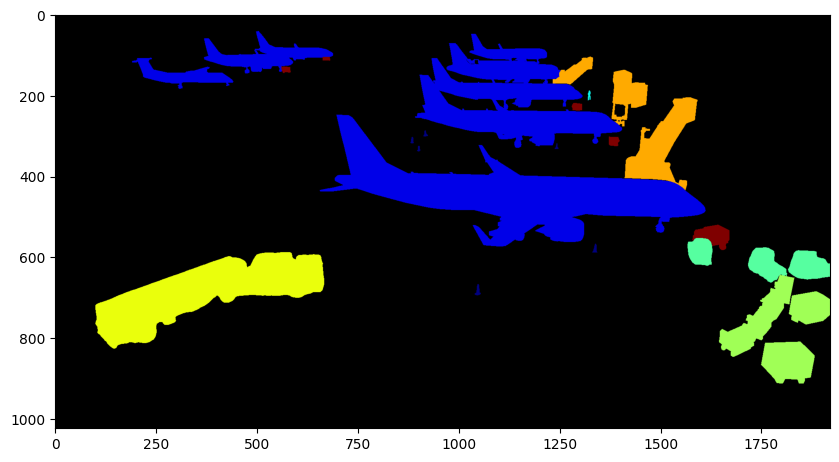

In [7]:
# See mask --- Different classes

# Create an empty mask
mask = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

# Define a colormap to use for the different category IDs
colors = plt.cm.jet(np.linspace(0, 1, len(cat_ids)))

color_map = {cat_id: colors[i] for i, cat_id in enumerate(cat_ids)}

for ann in anns:
    # Get the mask for this annotation
    ann_mask = coco.annToMask(ann)
    
    # Use the color defined by the category ID in the colormap
    mask[ann_mask > 0] = (color_map[ann['category_id']][:3] * 255).astype(np.uint8)

# Display the mask
plt.figure(figsize=(10,15))
plt.imshow(mask)
plt.show()